## Importing Libraries and Dataset

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import h5py
import time

# Retrieve a class of functions for splitting the data
from sklearn.model_selection import train_test_split

# Principal Component Analysis
from sklearn.decomposition import PCA

# Assessing performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

# Keras Imports
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

np.random.seed(42)
tf.random.set_seed(42)

## Inspecting the Dataset

In [ ]:
fid = h5py.File("dataset_patchcamelyon.h5", "r")
X, y = fid["X"][:]/255., fid["Y"][:].flatten()
fid.close()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
print("X_train shape:", X_train.shape, "\nX_val shape:", X_val.shape, "\nX_test shape:", X_test.shape)

X_train shape: (1600, 96, 96, 3) 
X_val shape: (400, 96, 96, 3) 
X_test shape: (500, 96, 96, 3)


In [5]:
print("y_train shape:", y_train.shape, "\ny_val shape:", y_val.shape, "\ny_test shape:", y_test.shape)

y_train shape: (1600,) 
y_val shape: (400,) 
y_test shape: (500,)


In [ ]:
def plot_image(data):
    arr = np.squeeze(data)
    plt.imshow(arr)
    plt.show()

In [ ]:
def plot_images(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.squeeze(instance) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Let's look at images that contain no metastases (`Y=0`)

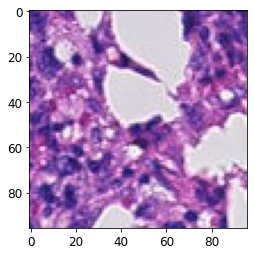

In [8]:
plot_image(X_train[y_train == 0][0])

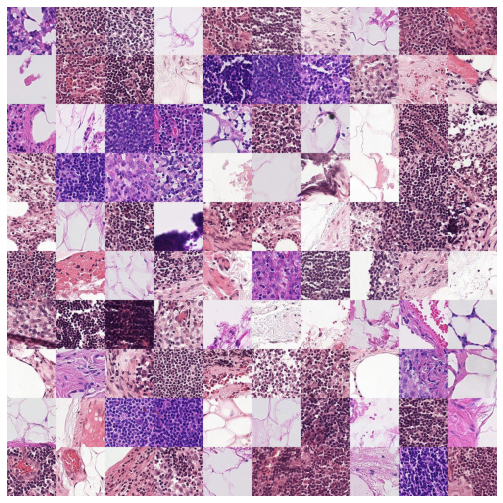

In [9]:
plt.figure(figsize=(9,9))
X_0 = X_train[y_train == 0]
example_images = X_0[:100]
plot_images(example_images, images_per_row=10)

Let's look at images that contains metastases (`Y=1`)

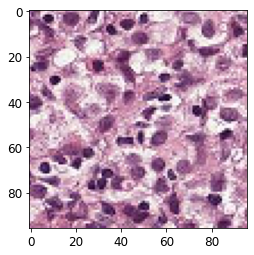

In [10]:
plot_image(X_train[y_train == 1][0])

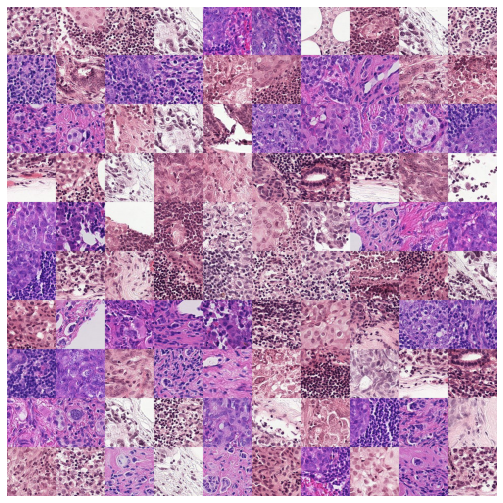

In [11]:
plt.figure(figsize=(9,9))
X_1 = X_train[y_train == 1]
example_images = X_1[:100]
plot_images(example_images, images_per_row=10)

## Building our CNN

Since we are attacking a binary classification problem, we are ending the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [ ]:
keras.backend.clear_session()

In [ ]:
# callback function used to early stop training if no improvement happens for 5 epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

Because we only have relatively few training samples, overfitting is going to be our number one concern. A 
number of techniques that can help mitigate overfitting include dropout and weight decay (L2 regularization). Here we will add a big dropout value.

In [ ]:
# Define the CNN architecture
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME", input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)      

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Data should be formatted into appropriately pre-processed floating point tensors before being fed into our network and the pixel values should be (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values).

In [17]:
n_epochs = 50

history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystop_cb])

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6907 - acc: 0.5437 - val_loss: 0.6755 - val_acc: 0.6600
Epoch 2/50
1600/1600 [==============================] - 1s 927us/step - loss: 0.6498 - acc: 0.6556 - val_loss: 0.6212 - val_acc: 0.6625
Epoch 3/50
1600/1600 [==============================] - 1s 930us/step - loss: 0.5830 - acc: 0.7056 - val_loss: 0.5084 - val_acc: 0.7825
Epoch 4/50
1600/1600 [==============================] - 1s 924us/step - loss: 0.5438 - acc: 0.7494 - val_loss: 0.4860 - val_acc: 0.7800
Epoch 5/50
1600/1600 [==============================] - 2s 944us/step - loss: 0.5285 - acc: 0.7519 - val_loss: 0.4489 - val_acc: 0.7925
Epoch 6/50
1600/1600 [==============================] - 2s 941us/step - loss: 0.5008 - acc: 0.7725 - val_loss: 0.4432 - val_acc: 0.7750
Epoch 7/50
1600/1600 [==============================] - 1s 937us/step - loss: 0.4918 - acc: 0.7694 - val_loss: 0.5874 - val_acc: 0.7150
Epo

In [ ]:
model.save('metastases_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

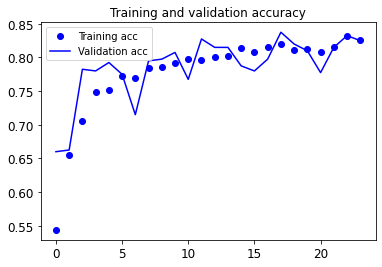

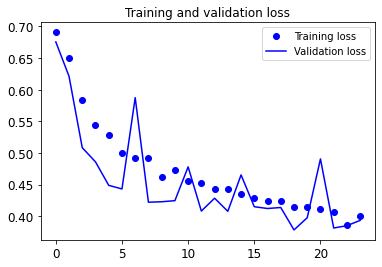

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

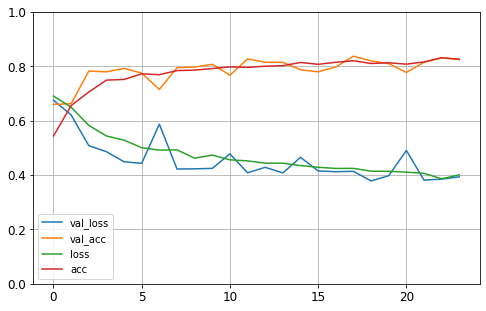

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate on Test Set

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

500/500 [==============================] - 0s 531us/step
Test Accuracy: 0.8339999914169312


In [ ]:
# Confusion Matrix and Classification Report
prob = model.predict(X_test)
prob[prob < 0.5] = 0
prob[prob >= 0.5] = 1

y_pred = prob.flatten().astype(int)

In [23]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[194  53]
 [ 30 223]]


In [24]:
print('Classification Report')
target_names = ['No metastases', 'Metastases']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
               precision    recall  f1-score   support

No metastases       0.87      0.79      0.82       247
   Metastases       0.81      0.88      0.84       253

     accuracy                           0.83       500
    macro avg       0.84      0.83      0.83       500
 weighted avg       0.84      0.83      0.83       500



This model performs relatively well compared to the supervised solutions that were tried earlier. The highest f1-score from the first solution was 0.80 while this classifier has an f1-score 0.83.  

## Using Data Augmentation

Now, we add a pre-processing step (data augmentation) and try to see if remixing our relatively small dataset will impact out

In [ ]:
datagen = ImageDataGenerator(rotation_range=90,
                             vertical_flip=True,
                             horizontal_flip=True,
                             fill_mode='nearest')

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `vertical_flip` is for randomly flipping half of the images vertically -- relevant when there are no assumptions of vertical 
asymmetry.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry.
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

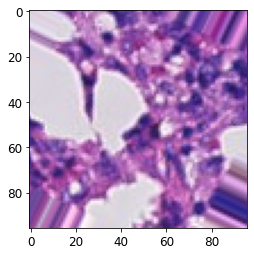

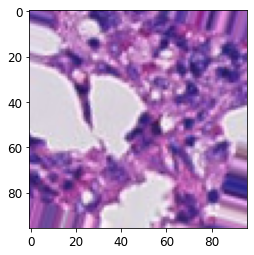

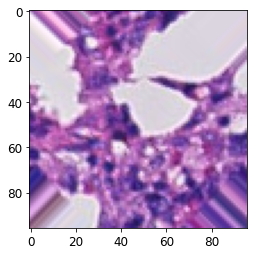

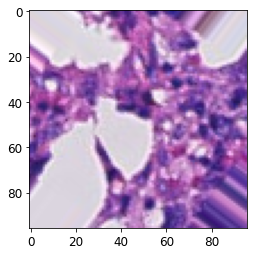

In [27]:
x = X_train[0]

# Reshape it to (1, 96, 96, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting.

In [ ]:
keras.backend.clear_session()

In [ ]:
# Define the CNN architecture
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME", input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=1, activation="relu", padding="SAME"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=90,
                                   vertical_flip=True,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train)
validation_generator = test_datagen.flow(X_val, y_val)

In [32]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              callbacks=[earlystop_cb])

Epoch 1/50
100/100 [==============================] - 8s 80ms/step - loss: 0.6683 - acc: 0.5856 - val_loss: 0.5891 - val_acc: 0.6300
Epoch 2/50
100/100 [==============================] - 8s 77ms/step - loss: 0.5697 - acc: 0.7272 - val_loss: 0.5067 - val_acc: 0.7700
Epoch 3/50
100/100 [==============================] - 8s 76ms/step - loss: 0.5242 - acc: 0.7584 - val_loss: 0.4528 - val_acc: 0.7775
Epoch 4/50
100/100 [==============================] - 8s 76ms/step - loss: 0.5030 - acc: 0.7697 - val_loss: 0.6358 - val_acc: 0.7975
Epoch 5/50
100/100 [==============================] - 8s 76ms/step - loss: 0.4867 - acc: 0.7822 - val_loss: 0.3461 - val_acc: 0.7575
Epoch 6/50
100/100 [==============================] - 8s 76ms/step - loss: 0.4886 - acc: 0.7731 - val_loss: 0.3658 - val_acc: 0.7950
Epoch 7/50
100/100 [==============================] - 8s 75ms/step - loss: 0.4805 - acc: 0.7887 - val_loss: 0.6084 - val_acc: 0.7850
Epoch 8/50
100/100 [==============================] - 8s 76ms/step - 

In [ ]:
model.save('metastases_2.h5')

Let's plot our results again:

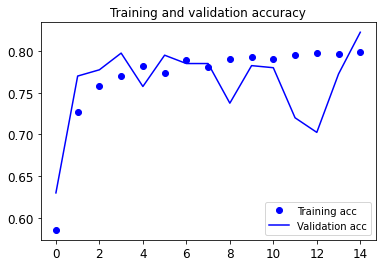

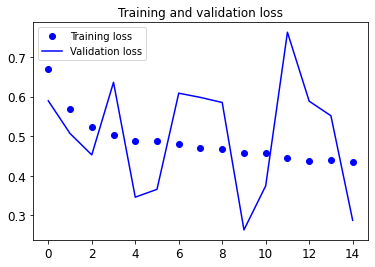

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities.

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

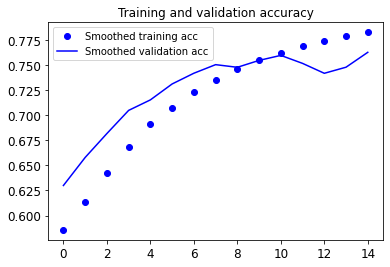

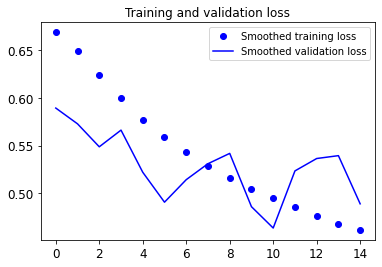

In [36]:
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

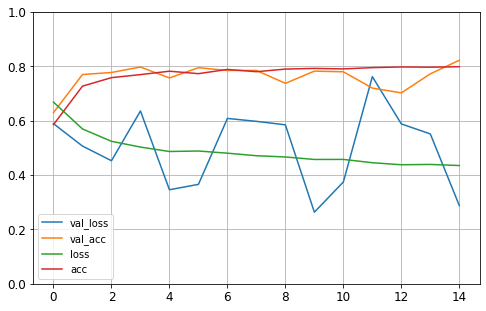

In [37]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Applying data augmentation made our model worse.

In [38]:
test_generator = test_datagen.flow(X_test, y_test, shuffle=False)

test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test Accuracy:', test_acc)

Test Accuracy: 0.7279999852180481


In [ ]:
test_generator.reset()

# Confusion Matrix and Classification Report
prob = model.predict_generator(test_generator)
prob[prob < 0.5] = 0
prob[prob >= 0.5] = 1

y_pred = prob.flatten().astype(int)

In [40]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[176  71]
 [ 65 188]]


In [41]:
print('Classification Report')
target_names = ['No metastases', 'Metastases']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
               precision    recall  f1-score   support

No metastases       0.73      0.71      0.72       247
   Metastases       0.73      0.74      0.73       253

     accuracy                           0.73       500
    macro avg       0.73      0.73      0.73       500
 weighted avg       0.73      0.73      0.73       500



As it turns out, data augmentation was not the right choice as a pre-processing step. It seems that the remixed images that data augmentation creates are not a valid domain in our dataset. They are harming the training process by simply providing the network invalid inputs which may be making the network learn spurious patterns in the data.

## Fine-tuning a MLP Classifier with PCA

In [42]:
X.shape

(2500, 96, 96, 3)

In [ ]:
nsamples, nx, ny, nz = X.shape
X = X.reshape((nsamples, nx*ny*nz))

In [44]:
X.shape

(2500, 27648)

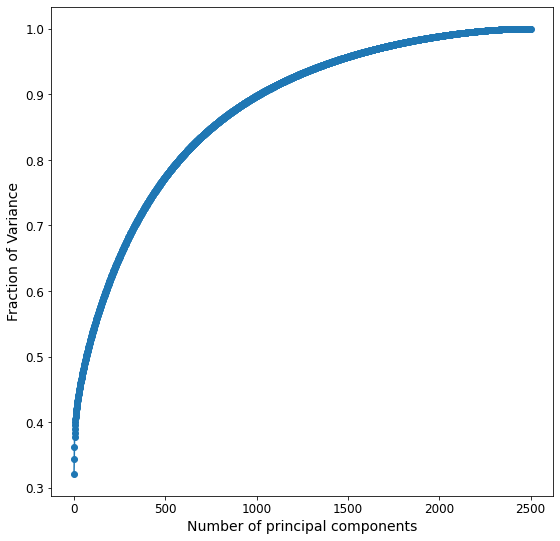

1418 components of the total 2500 components account for 95% of variance


In [47]:
# create the principal components of the training data
pcaval = PCA()
pcaval.fit(X)

# compute how much variance is explained by each component
CUMSUM = np.cumsum(pcaval.explained_variance_ratio_)

plt.figure(figsize=(9,9))
plt.plot(range(1,2501), CUMSUM, marker="o")
plt.xlabel("Number of principal components")
plt.ylabel("Fraction of Variance")
plt.show()

# print out how many components explain at least 95% of the variance
dmax = np.argmax(CUMSUM >= 0.95) + 1
print(dmax, "components of the total", pcaval.explained_variance_ratio_.size, "components account for 95% of variance")

In [48]:
# Perform a principal component decomposition and keep the first "dmax" components
t1 = time.time()
pcaval = PCA(n_components = dmax)
X_pca = pcaval.fit_transform(X)
t2 = time.time()
print("X_pca:", X_pca.shape, "\t computational time =", t2-t1, "s")

X_pca: (2500, 1418) 	 computational time = 81.64937734603882 s


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [69]:
X_train.shape

(1600, 1418)

In [70]:
X_val.shape

(400, 1418)

In [ ]:
keras.backend.clear_session()

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-4, input_shape=[1418]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))

    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    return model

In [ ]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [140]:
keras_clf.fit(X_train, y_train, epochs=100,
              validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 0s 149us/step - loss: 0.7782 - acc: 0.5312 - val_loss: 0.7447 - val_acc: 0.5525
Epoch 2/100
1600/1600 [==============================] - 0s 86us/step - loss: 0.7097 - acc: 0.5650 - val_loss: 0.7202 - val_acc: 0.5500
Epoch 3/100
1600/1600 [==============================] - 0s 100us/step - loss: 0.6533 - acc: 0.6119 - val_loss: 0.6982 - val_acc: 0.5725
Epoch 4/100
1600/1600 [==============================] - 0s 110us/step - loss: 0.6021 - acc: 0.6587 - val_loss: 0.6788 - val_acc: 0.5875
Epoch 5/100
1600/1600 [==============================] - 0s 94us/step - loss: 0.5555 - acc: 0.7056 - val_loss: 0.6621 - val_acc: 0.5975
Epoch 6/100
1600/1600 [==============================] - 0s 99us/step - loss: 0.5133 - acc: 0.7500 - val_loss: 0.6477 - val_acc: 0.6025
Epoch 7/100
1600/1600 [==============================] - 0s 102us/step - loss: 0.4745 - acc: 0.7931 - val_loss: 0.6350 - val_acc: 0.62

### Evaluate on Test Set

In [143]:
y_pred = keras_clf.predict(X_test)

print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report")
target_names = ["No metastases", "Metastases"]
print(classification_report(y_test, y_pred, target_names=target_names))


Confusion Matrix
 [[171  76]
 [ 88 165]]

Classification Report
               precision    recall  f1-score   support

No metastases       0.66      0.69      0.68       247
   Metastases       0.68      0.65      0.67       253

     accuracy                           0.67       500
    macro avg       0.67      0.67      0.67       500
 weighted avg       0.67      0.67      0.67       500



### Fine-Tune the Model

In [ ]:
keras.backend.clear_session()

In [ ]:
f1 = make_scorer(f1_score , average='macro')

In [150]:
n_neurons = [i for i in range(1, 100)]

param_distribs = {
    "n_hidden": [0, 1, 2, 3, 4, 5, 6, 7],
    "n_neurons": n_neurons,
    "learning_rate": [1e-4, 1e-3, 2e-3],
}

rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3, verbose=2, n_jobs=-1, scoring=f1)

rnd_search_cv.fit(X_train, y_train, epochs=100,
              validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   55.1s finished


Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 0s 190us/step - loss: 0.5926 - acc: 0.6669 - val_loss: 0.5334 - val_acc: 0.7050
Epoch 2/100
1600/1600 [==============================] - 0s 119us/step - loss: 0.2506 - acc: 0.9194 - val_loss: 0.6560 - val_acc: 0.7150
Epoch 3/100
1600/1600 [==============================] - 0s 109us/step - loss: 0.0415 - acc: 0.9925 - val_loss: 1.0392 - val_acc: 0.6900
Epoch 4/100
1600/1600 [==============================] - 0s 108us/step - loss: 0.0068 - acc: 0.9994 - val_loss: 1.6060 - val_acc: 0.6975
Epoch 5/100
1600/1600 [==============================] - 0s 112us/step - loss: 1.3885e-04 - acc: 1.0000 - val_loss: 1.9696 - val_acc: 0.7025
Epoch 6/100
1600/1600 [==============================] - 0s 112us/step - loss: 8.3815e-06 - acc: 1.0000 - val_loss: 2.4002 - val_acc: 0.7100
Epoch 7/100
1600/1600 [==============================] - 0s 111us/step - loss: 4.6757e-07 - acc: 1.0000 - val_loss: 2.8512 

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f03625a0a20>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.002],
                                        'n_hidden': [0, 1, 2, 3, 4, 5, 6, 7],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(f1_score, average=macro), verbose=2)

In [151]:
rnd_search_cv.best_params_

{'learning_rate': 0.001, 'n_hidden': 4, 'n_neurons': 67}

In [152]:
rnd_search_cv.best_score_

0.7014621224143601

In [153]:
model = rnd_search_cv.best_estimator_.model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 67)                95073     
_________________________________________________________________
dense_2 (Dense)              (None, 67)                4556      
_________________________________________________________________
dense_3 (Dense)              (None, 67)                4556      
_________________________________________________________________
dense_4 (Dense)              (None, 67)                4556      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 68        
Total params: 108,809
Trainable params: 108,809
Non-trainable params: 0
_________________________________________________________________


## Evaluate on Test Set

In [154]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

500/500 [==============================] - 0s 56us/step
Test Accuracy: 0.7419999837875366


In [ ]:
# Confusion Matrix and Classification Report
prob = model.predict(X_test)
prob[prob < 0.5] = 0
prob[prob >= 0.5] = 1

y_pred = prob.flatten().astype(int)

In [156]:
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[176  71]
 [ 58 195]]


In [157]:
print('Classification Report')
target_names = ['No metastases', 'Metastases']
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report
               precision    recall  f1-score   support

No metastases       0.75      0.71      0.73       247
   Metastases       0.73      0.77      0.75       253

     accuracy                           0.74       500
    macro avg       0.74      0.74      0.74       500
 weighted avg       0.74      0.74      0.74       500



Although `MLP` performs worse than `CNN` in this case, tuning the hyperparameters did actually boost its performance.